# GEOG 5160 6160 Lab 11

# Introduction

In this lab, we'll look at working with time series data in deep learning models. The trick with all time series is to make predictions that consider not just the current time step, but also information from previous time steps. We'll do this in two ways here. First, we'll process the data for a 'predict-ahead' model. In this, the outcome or target at time $t$ will be modeled using the set of covariates at time $t-1$, plus the value of the outcome at $t-1$. This is a short-term predictive model in which we only use information from the previous time step to predict the target for the next time step. The second approach will be to use a recurrent neural network. These are models that are designed to incorporate a memory track, that retains some information about the relationship between variables from the previous time steps. We'll use the LSTM model (long/short-term memory), as this can include information over short and longer time steps. We'll build a series of models here of increasing complexity. As you go through this, pay attention to the relative gains (or losses) in predictive skill relative to the increases in model complexity.

The models we'll build are modified from: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/, as well as the Deep Learning with Python book (Chollet 2024).

## Objectives

- Process data for time series modeling
- Build and test a recurrent neural network (LSTM)
- Extend the base LSTM model

# Data processing

The data we'll use is a time series of hourly air quality measurements from the US Embassy in Beijing from 2010 to 2014, together with corresponding weather data from Beijing Capital International Airport. Start by loading some of the libraries we'll need:

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import keras
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

Now load the data and take a look at the first few lines:

In [2]:
# load dataset
dataset = pd.read_csv('./datafiles/pollution.csv', header=0, index_col=0)
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


The column labelled `pollution` is the target for prediction (this is PM2.5 measurements in ppb). 

We'll now set up the data for modeling. First, we''ll convert from the Pandas dataframe to a numpy array:

In [3]:
values = dataset.values

Let's plot out the series to see the trends and patterns (you should see a fairly strong seasonal cycle in most of the variables)

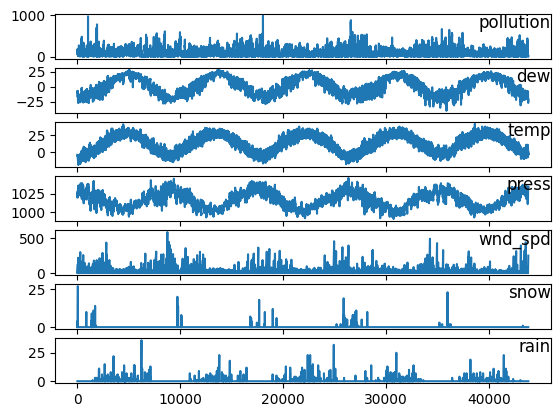

In [4]:
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

Next, we need to deal with the wind direction variable which is a string:

In [5]:
dataset.wnd_dir.value_counts()

wnd_dir
SE    15290
NW    14130
cv     9384
NE     4996
Name: count, dtype: int64

We'll encode this variable to a numeric representation using Scikit-Learn's `LabelEncoder`. Rather than converting to a series of binary values (c.f. one-hot encoding), this will label each category with an integer value. After conversion, we make sure that all variables are represented as numeric floats (as tensorflow expects this)

In [6]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')

Now we'll normalize the variables to 0-1 range for training:

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

Normally, we'd only normalize the features, but as we are going to use the PM2.5 value from the previous time step as an additional feature, we need to normalize this as well. As this means we will be modeling the normalized PM2.5 values, we'll store the minimum and maximum. This will allow us to back convert any predictions we make to parts per billion. 

In [8]:
pollution_min = np.min(values[:,0])
pollution_max = np.max(values[:,0])

print('PM2.5 Min: %.2f; Max: %.2f' % (pollution_min, pollution_max))

PM2.5 Min: 0.00; Max: 994.00


Now let's set up the data for time series modeling. As explained above, we want to estimate the air quality ($y$) at time $t$ using other variables at $t-1$. In time series terms, this is an VAR1 model, and can be written as:

$$
y_{t} = X_{t-1} + e
$$

The easiest way to do this is to create a series of *lagged* variables - i.e. we'll create a set of vectors of variables that are shifted by one day, so that the value of temperature (for example) on Jan 1 is attributed to Jan 2. This has the effect of linking the outcome variable on Jan 2 with the previous days value of temperature (and other features). We'll use a function created by Jason Brownlee to do this. This makes use of Pandas' `shift` function that will shift a vector of values by a set number of places. To illustrate what this does, the following code creates a small vector of numbers (0-10) and then shifts this both forward and backwards:

In [9]:
df = pd.DataFrame({'x': np.arange(10)})
df['(x+1)'] = df.shift(1)['x']
df['(x-1)'] = df.shift(-1)['x']
print(df)

   x  (x+1)  (x-1)
0  0    NaN    1.0
1  1    0.0    2.0
2  2    1.0    3.0
3  3    2.0    4.0
4  4    3.0    5.0
5  5    4.0    6.0
6  6    5.0    7.0
7  7    6.0    8.0
8  8    7.0    9.0
9  9    8.0    NaN


The function uses this in a very general way which will allow us to create more complex data later on. For now, let's set it up and create our lagged dataset. The function takes three arguments:

- The dataset that containes the data to be lagged (as a Pandas dataframe)
- The number of lags to create (e.g. `n_in=2` will create variables at 1 and 2 lags / time steps prior to the observation)
- The number of forward steps to create. We won't use this here, but this sets up data to make predictions for multiple steps ahead

In [10]:
from pandas import concat
from pandas import DataFrame
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0


You'll see in the output that this has relabled the data by column number (e.g. `var1`), and by the lag (`(t-1)`). It also keeps the original unlagged data (`(t)`).  If you look, you should see that the value at row 1 of any variable at `t-1` corresponds to the same value at row 0 at `t`.

For our initial model, we only want to keep the variables at time $t-1$ and the pollutant values at time $t$ (`var1(t)`) as a target. We'll remove the last 7 columns.

In [12]:
reframed = reframed.iloc[:, :-7]
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


Next, we'll  split the data into training/testing. For speed, we'll only use the first year for training, and evaluate on the remaining 4 years. You might want to come back to this and increase the amount of training data at a later point to see the impact on the model. 

In [13]:
# split into train and test sets
values = reframed.values
n_yr_train = 1
n_train_hours = 365 * 24 * n_yr_train ## Number of training points
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
# Data shapes
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8760, 8) (8760,) (35039, 8) (35039,)


# Model 1: Dense network

To start with, we'll build a simple neural network with a single densely connected layer with 50 nodes between the input and output.  We'll build a pretty simple model with 

- A input layer. Each observation going into the model is the set of 7 features (temperature, etc) from the previous time step and the pollution from the previous step, which gives a shape of (8,)
- A densely connected layer with 50 nodes
- An output layer. We're only predicting the pollution value, so there's only a single output. Note that as this is a continuous outcome, we don't specify an activation function (as this would constrain the output of the model).

In [14]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential([   
      layers.Input(shape=(8,)),                     
      layers.Dense(50),
      layers.Dense(1)
])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 501 (1.96 KB)

 Trainable params: 501 (1.96 KB)

 Non-trainable params: 0 (0.00 B)

None


A grand total of 501 parameters to train here. We'll use the Adam optimizer with a learning rate of 1x10^-3, mean squared error (`mse`) for the loss function, and evaluate with the mean absolute error (`mae`)

In [15]:
myoptim = keras.optimizers.Adam(learning_rate=1e-3)
myloss = "mse"
mymetric = ["mae"]
model.compile(optimizer=myoptim, loss=myloss, metrics=mymetric)

We'll set a callback to save the model, and only update this if it improves during training

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint("aq_model1.keras",
                                    save_best_only=True)
]

And fit. This should run pretty quickly, as the model is simple. 

In [17]:
# fit network
history = model.fit(X_train, y_train, 
                    epochs=10, batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=callbacks,
                    verbose=2, shuffle=False)

Epoch 1/10
137/137 - 1s - 4ms/step - loss: 0.0123 - mae: 0.0847 - val_loss: 0.0244 - val_mae: 0.1347
Epoch 2/10
137/137 - 0s - 2ms/step - loss: 0.0033 - mae: 0.0431 - val_loss: 0.0127 - val_mae: 0.0943
Epoch 3/10
137/137 - 0s - 2ms/step - loss: 0.0017 - mae: 0.0282 - val_loss: 0.0058 - val_mae: 0.0627
Epoch 4/10
137/137 - 0s - 2ms/step - loss: 0.0012 - mae: 0.0201 - val_loss: 0.0029 - val_mae: 0.0430
Epoch 5/10
137/137 - 0s - 2ms/step - loss: 0.0010 - mae: 0.0166 - val_loss: 0.0018 - val_mae: 0.0328
Epoch 6/10
137/137 - 0s - 2ms/step - loss: 9.8368e-04 - mae: 0.0158 - val_loss: 0.0016 - val_mae: 0.0296
Epoch 7/10
137/137 - 0s - 2ms/step - loss: 9.8557e-04 - mae: 0.0158 - val_loss: 0.0015 - val_mae: 0.0288
Epoch 8/10
137/137 - 0s - 2ms/step - loss: 9.9303e-04 - mae: 0.0160 - val_loss: 0.0015 - val_mae: 0.0294
Epoch 9/10
137/137 - 0s - 2ms/step - loss: 9.9952e-04 - mae: 0.0162 - val_loss: 0.0016 - val_mae: 0.0313
Epoch 10/10
137/137 - 0s - 1ms/step - loss: 0.0010 - mae: 0.0164 - val_loss

If we plot the loss curves, you'll see that it is pretty stable (it is possible that it may need to be run for a little longer)

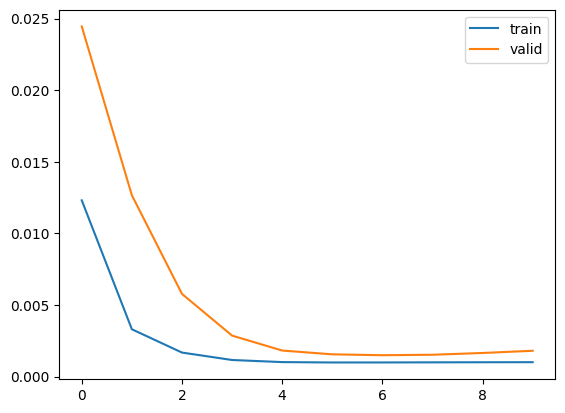

In [18]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

We'll now evaluate to get the model loss and mean absolute error. We'll create a function for this as we are going to be testing multiple models

In [19]:
def calc_mae(model, X_test, y_test):
    test_mse_score, test_mae_score = model.evaluate(X_test, y_test, verbose=0)
    print(f'Mean squared error: {np.round(test_mse_score, 5)}')
    print(f'Mean absolute error: {np.round(test_mae_score, 5)}')

In [20]:
model = keras.models.load_model("aq_model1.keras")
calc_mae(model, X_test, y_test)

Mean squared error: 0.00149
Mean absolute error: 0.02881


And we get a value of around 0.03 (this varies quite a bit in practice, which also suggests that the model may need further training). To put this error into context, we rescaled the pollutant values to a [0-1] range, so an error of aorund 0.03 equates to about 3% of the original range

We can also see how well this predicts over time for the test data. We'll predict for every observation in the dataset and plot against the observed test set. We'll restrict this to the first 1000 observations for plotting to see a little more of the detail.

1095/1095 ━━━━━━━━━━━━━━━━━━━━ 0s 190us/step


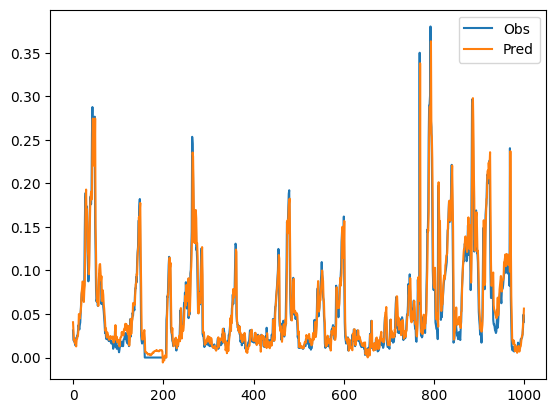

In [21]:
y_test_pred_norm = model.predict(X_test)
plt.plot(y_test[0:1000], label="Obs")
plt.plot(y_test_pred_norm[0:1000], label="Pred")
plt.legend()

And we can plot the individual observations and predictions together - these should follow a 1:1 line:

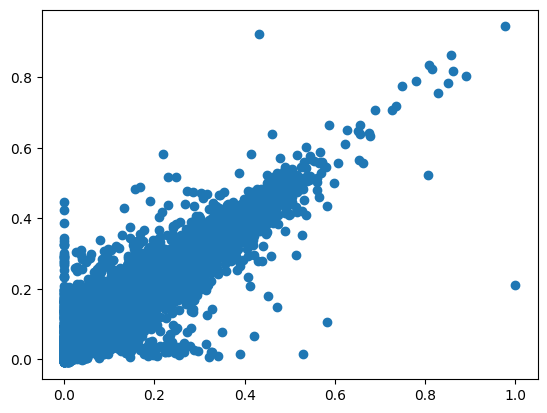

In [22]:
plt.plot(y_test, y_test_pred_norm, 'o')

# Model 2: LSTM 

For the next model, we'll add an LSTM layer. This is a more complex layer, that includes weights that link inputs to the outputs, but also that link a saved or memory state to the current input. 

However, before setting this up, we need to reformat the input data. For time series models, the input shape needs to be three dimensional `(i,j,k)`, where `i` is the number of samples (this is the number of hourly observations), `j` is the number of time steps in each sequence and `k` is the number of features. `j` controls the number of previous time steps linked to an outcome, and this is a key parameter: higher values for `k` means that the model is considering a longer period of observations *prior* to the time step we are trying to predict. We'll start by reusing the dataset we created for the densely connected model above. All we need to do here is to use the `reshape` method to add the additional axis for `j` here:

In [23]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (8760, 1, 8)
X_test: (35039, 1, 8)


Now we'll build the model. Couple of things to note here: 

- The input layer needs to parameters: the first defines `j` (the number of time steps in each sequence) and the second defines `k`, the number of features
- The LSTM layer takes a single argument which is the number of units in the layer. Each of these can be used to model a different part of the relationship between past values and the present

In [24]:
model = models.Sequential([                        
      layers.Input(shape=(X_train.shape[1], X_train.shape[2])),                     
      layers.LSTM(100),
      layers.Dense(1)
])

In [25]:
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        43,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,701 (170.71 KB)

 Trainable params: 43,701 (170.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Our model is a little bigger now, at just over 43,000 parameters. Each unit in the LSTM layer has multiple weights: some to connect the input values, and some to control the contribution of previous information

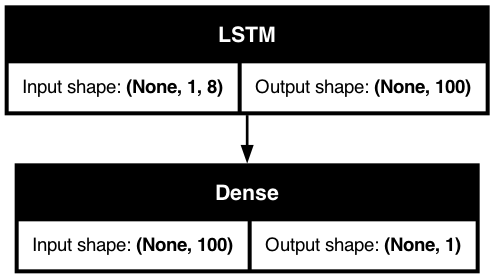

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, dpi=96)

Next, we'll do the usual steps of compiling the model, setting up a callback and then training the model. We'll train for a higher number of epochs as we have amore complex model

In [27]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=myloss, metrics=mymetric)
callbacks = [
    keras.callbacks.ModelCheckpoint("aq_model2.keras",
                                    save_best_only=True)
]

In [28]:
# fit network
history = model.fit(X_train, y_train, 
                    epochs=30, batch_size=64, 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks,
                    verbose=2, shuffle=False)

Epoch 1/30
137/137 - 1s - 7ms/step - loss: 0.0064 - mae: 0.0592 - val_loss: 0.0076 - val_mae: 0.0761
Epoch 2/30
137/137 - 0s - 2ms/step - loss: 0.0029 - mae: 0.0388 - val_loss: 0.0077 - val_mae: 0.0749
Epoch 3/30
137/137 - 0s - 2ms/step - loss: 0.0014 - mae: 0.0252 - val_loss: 0.0056 - val_mae: 0.0611
Epoch 4/30
137/137 - 0s - 2ms/step - loss: 0.0011 - mae: 0.0197 - val_loss: 0.0035 - val_mae: 0.0471
Epoch 5/30
137/137 - 0s - 2ms/step - loss: 0.0010 - mae: 0.0175 - val_loss: 0.0025 - val_mae: 0.0388
Epoch 6/30
137/137 - 0s - 2ms/step - loss: 9.8477e-04 - mae: 0.0165 - val_loss: 0.0020 - val_mae: 0.0338
Epoch 7/30
137/137 - 0s - 2ms/step - loss: 9.7481e-04 - mae: 0.0160 - val_loss: 0.0017 - val_mae: 0.0306
Epoch 8/30
137/137 - 0s - 2ms/step - loss: 9.7015e-04 - mae: 0.0157 - val_loss: 0.0015 - val_mae: 0.0284
Epoch 9/30
137/137 - 0s - 2ms/step - loss: 9.6858e-04 - mae: 0.0155 - val_loss: 0.0014 - val_mae: 0.0269
Epoch 10/30
137/137 - 0s - 2ms/step - loss: 9.6907e-04 - mae: 0.0155 - val_

The loss curves show that the model stabilizes somewhere around 15 epochs or so

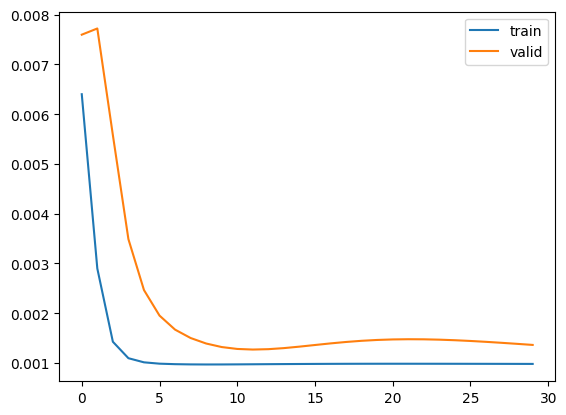

In [29]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

And we'll evaluate for the test set. You should get a small improvement here, but not a great deal. The reason for this is that we are using a model that tries to link past information to the present, but we have only used 1 previous time step. We'll address this next

In [30]:
model = keras.models.load_model("aq_model2.keras")
calc_mae(model, X_test, y_test)

Mean squared error: 0.00127
Mean absolute error: 0.02503


# Model 3: LSTM with multiple time steps

For this next model, we'll link sequences of 12 hours of data to each observation point. Each input tensor will have the shape (12, 8), and the overall input dataframe will be (n, 12, 8), where `n` is the total number of observations in the training set. Note that this will be smaller that the `n` for the previous dataset, as we lose the first 12 observations (as there are not enough preceding values to make the sequences). Note that 12 is a fairly small sequence to use here - for daily data, we might want to use 24 steps or even several days worth of data prior to the observation point. 

First define the number of steps and features:

In [31]:
n_steps = 12
n_features = 8

Now we'll reuse the function from above to make a dataframe with the 12 lags:

In [32]:
reframed = series_to_supervised(scaled, n_steps, 1)
reframed

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var6(t-12),var7(t-12),var8(t-12),var1(t-11),var2(t-11),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
12,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,...,0.0,0.0,0.148893,0.470588,0.229508,0.636364,0.666667,0.039716,0.0,0.0
13,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,...,0.0,0.0,0.164990,0.470588,0.229508,0.618183,0.666667,0.046586,0.0,0.0
14,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,...,0.0,0.0,0.158954,0.455882,0.229508,0.618183,0.666667,0.053456,0.0,0.0
15,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,...,0.0,0.0,0.154930,0.455882,0.229508,0.618183,0.666667,0.060326,0.0,0.0
16,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,...,0.0,0.0,0.159960,0.455882,0.229508,0.636364,0.666667,0.063385,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,0.008048,0.264706,0.229508,0.781818,0.333333,0.243664,0.000000,0.0,0.008048,0.264706,...,0.0,0.0,0.008048,0.250000,0.278689,0.781818,0.333333,0.395659,0.0,0.0
43796,0.008048,0.264706,0.229508,0.781818,0.333333,0.255883,0.000000,0.0,0.008048,0.264706,...,0.0,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.405588,0.0,0.0
43797,0.008048,0.264706,0.262295,0.781818,0.333333,0.265812,0.000000,0.0,0.007042,0.264706,...,0.0,0.0,0.010060,0.264706,0.262295,0.781818,0.333333,0.413996,0.0,0.0
43798,0.007042,0.264706,0.278689,0.781818,0.333333,0.278031,0.000000,0.0,0.012072,0.264706,...,0.0,0.0,0.008048,0.264706,0.245902,0.781818,0.333333,0.420866,0.0,0.0


Remove the last 7 columns (the features at time `t`):

In [33]:
reframed = reframed.iloc[:, :-7]
reframed.head()

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var6(t-12),var7(t-12),var8(t-12),var1(t-11),var2(t-11),...,var8(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
12,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,...,0.0,0.152918,0.470588,0.229508,0.636364,0.666667,0.034367,0.0,0.0,0.148893
13,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,...,0.0,0.148893,0.470588,0.229508,0.636364,0.666667,0.039716,0.0,0.0,0.164990
14,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,...,0.0,0.164990,0.470588,0.229508,0.618183,0.666667,0.046586,0.0,0.0,0.158954
15,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,...,0.0,0.158954,0.455882,0.229508,0.618183,0.666667,0.053456,0.0,0.0,0.154930
16,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,...,0.0,0.154930,0.455882,0.229508,0.618183,0.666667,0.060326,0.0,0.0,0.159960


Split thsi new dataframe into training and testing sets

In [38]:
# split into train and test sets
values = reframed.values
n_yr_train = 1
n_train_hours = 365 * 24 * n_yr_train ## Number of training points
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
# Data shapes
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8760, 96) (8760,) (35028, 96) (35028,)


And reshape to have the expected 3D tensor

In [40]:
X_train = X_train.reshape((X_train.shape[0], n_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_features))
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (8760, 12, 8)
X_test: (35028, 12, 8)


Check that the second dimension of the `X` data is equal to the number of steps in each sequence. 

Now let's go ahead and build and train our model. We'll use the same architecture as the previous model, but a higher number of epochs

In [41]:
model = models.Sequential([                        
      layers.Input(shape=(n_steps, n_features)),                     
      layers.LSTM(100),
      layers.Dense(1)
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=myloss, metrics=mymetric)
callbacks = [
    keras.callbacks.ModelCheckpoint("aq_model3.keras",
                                    save_best_only=True)
]

In [42]:
# fit network 
history = model.fit(X_train, y_train, 
                    epochs=100, batch_size=64, 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks,
                    verbose=2, shuffle=False)

Epoch 1/100
137/137 - 2s - 13ms/step - loss: 0.0045 - mae: 0.0489 - val_loss: 0.0028 - val_mae: 0.0406
Epoch 2/100
137/137 - 1s - 8ms/step - loss: 0.0018 - mae: 0.0285 - val_loss: 0.0019 - val_mae: 0.0319
Epoch 3/100
137/137 - 1s - 8ms/step - loss: 0.0016 - mae: 0.0256 - val_loss: 0.0019 - val_mae: 0.0335
Epoch 4/100
137/137 - 1s - 8ms/step - loss: 0.0014 - mae: 0.0241 - val_loss: 0.0019 - val_mae: 0.0335
Epoch 5/100
137/137 - 1s - 8ms/step - loss: 0.0013 - mae: 0.0226 - val_loss: 0.0017 - val_mae: 0.0323
Epoch 6/100
137/137 - 1s - 8ms/step - loss: 0.0012 - mae: 0.0213 - val_loss: 0.0017 - val_mae: 0.0318
Epoch 7/100
137/137 - 1s - 8ms/step - loss: 0.0011 - mae: 0.0203 - val_loss: 0.0017 - val_mae: 0.0314
Epoch 8/100
137/137 - 1s - 8ms/step - loss: 0.0011 - mae: 0.0195 - val_loss: 0.0016 - val_mae: 0.0309
Epoch 9/100
137/137 - 1s - 8ms/step - loss: 0.0011 - mae: 0.0188 - val_loss: 0.0016 - val_mae: 0.0303
Epoch 10/100
137/137 - 1s - 8ms/step - loss: 0.0010 - mae: 0.0184 - val_loss: 0.0

The validation loss should hit a minimum around 50 or 60 epochs:

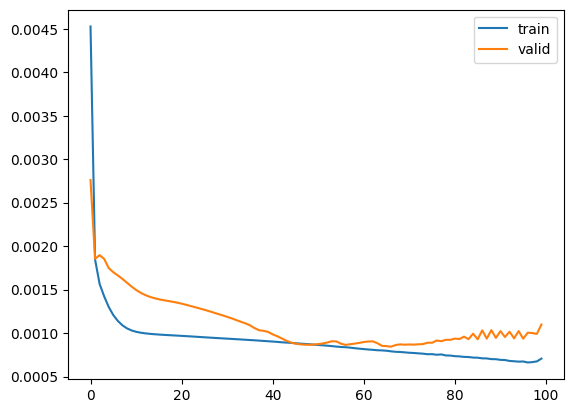

In [43]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

Evaluating on the test set shows a pretty decent drop from the previous model down to about 0.015 or about 1.5% of the range of the outcome

In [45]:
model = keras.models.load_model("aq_model3.keras")
calc_mae(model, X_test, y_test)

Mean squared error: 0.00084
Mean absolute error: 0.01595


# Extending the model

## Adding recurrent dropouts

We've previously explored the use of dropout layers to slow training and create more general models. We'll now use this to see if we can further improve model performance. As a reminder, dropouts randomly set some weights to zero, effectively removing them from affecting model predictions (this is what slows the training). For recurrent models like LSTMs dropouts have to be applied in a temporally constant manner by dropping some of the connections between data from different time steps. We'll add this with the `recurrent_dropout` argument, but otherwise keep the model the same

In [46]:
inputs = keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = layers.LSTM(100, recurrent_dropout=0.5)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [47]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 12, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        43,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,701 (170.71 KB)

 Trainable params: 43,701 (170.71 KB)

 Non-trainable params: 0 (0.00 B)

Let's now compile and train for 100 epochs:

In [48]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=myloss, metrics=mymetric)
callbacks = [
    keras.callbacks.ModelCheckpoint("aq_model4.keras",
                                    save_best_only=True)
]

In [49]:
# fit network
history = model.fit(X_train, y_train, 
                    epochs=100, batch_size=64, 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks,
                    verbose=2, shuffle=False)

Epoch 1/100
137/137 - 3s - 20ms/step - loss: 0.0047 - mae: 0.0515 - val_loss: 0.0036 - val_mae: 0.0474
Epoch 2/100
137/137 - 2s - 12ms/step - loss: 0.0021 - mae: 0.0313 - val_loss: 0.0025 - val_mae: 0.0389
Epoch 3/100
137/137 - 2s - 11ms/step - loss: 0.0018 - mae: 0.0276 - val_loss: 0.0022 - val_mae: 0.0369
Epoch 4/100
137/137 - 2s - 11ms/step - loss: 0.0016 - mae: 0.0255 - val_loss: 0.0019 - val_mae: 0.0336
Epoch 5/100
137/137 - 2s - 11ms/step - loss: 0.0015 - mae: 0.0246 - val_loss: 0.0018 - val_mae: 0.0331
Epoch 6/100
137/137 - 2s - 11ms/step - loss: 0.0014 - mae: 0.0237 - val_loss: 0.0016 - val_mae: 0.0303
Epoch 7/100
137/137 - 2s - 11ms/step - loss: 0.0014 - mae: 0.0232 - val_loss: 0.0018 - val_mae: 0.0321
Epoch 8/100
137/137 - 2s - 11ms/step - loss: 0.0013 - mae: 0.0228 - val_loss: 0.0015 - val_mae: 0.0287
Epoch 9/100
137/137 - 1s - 11ms/step - loss: 0.0013 - mae: 0.0225 - val_loss: 0.0017 - val_mae: 0.0316
Epoch 10/100
137/137 - 2s - 11ms/step - loss: 0.0013 - mae: 0.0219 - val_

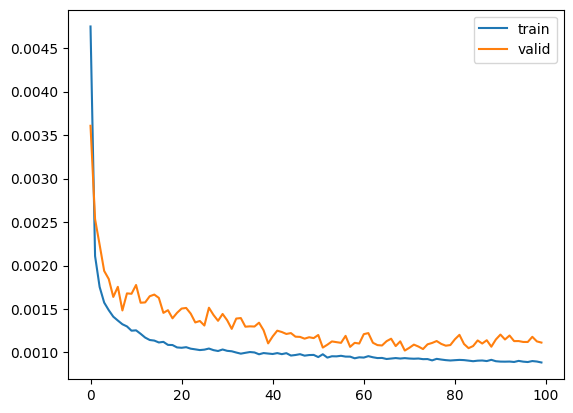

In [50]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [51]:
model = keras.models.load_model("aq_model4.keras")
calc_mae(model, X_test, y_test)

Mean squared error: 0.00102
Mean absolute error: 0.02002


In this case, adding the dropout makes the model worse. It's likely that we're getting close to the limit of what can be improved on with this model (and given that we took a realtively small amount of data for training). We could try to train this model for longer (or slower) to see if that improves things, but we'll instead try one final experiment in which we make the model more complex. 

## Stacked LSTM

Currently our model only has a single LSTM layer. But like CNNs, adding additional LSTM layers can improve model performance by identifying more complicated relationships between time steps. We'll add a second LSTM here with 50 nodes. Note that we also need to add an argument to the preceding LSTM layer `return_sequences=True`. This ensures that the output of LSTM layer 1 is presented to LSTM layer 2 as a time sequence. Let's follow all the usual steps of building, compiling, training and evaluating:

In [52]:
inputs = keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
x = layers.LSTM(100, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(50, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [53]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 12, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 12, 100)        │        43,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,851 (288.48 KB)

 Trainable params: 73,851 (288.48 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss=myloss, metrics=mymetric)
callbacks = [
    keras.callbacks.ModelCheckpoint("aq_model5.keras",
                                    save_best_only=True)
]

In [55]:
# fit network
history = model.fit(X_train, y_train, 
                    epochs=100, batch_size=64, 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks,
                    verbose=2, shuffle=False)

Epoch 1/100
137/137 - 5s - 34ms/step - loss: 0.0067 - mae: 0.0601 - val_loss: 0.0042 - val_mae: 0.0497
Epoch 2/100
137/137 - 3s - 24ms/step - loss: 0.0037 - mae: 0.0423 - val_loss: 0.0031 - val_mae: 0.0421
Epoch 3/100
137/137 - 3s - 24ms/step - loss: 0.0030 - mae: 0.0375 - val_loss: 0.0023 - val_mae: 0.0346
Epoch 4/100
137/137 - 3s - 21ms/step - loss: 0.0027 - mae: 0.0349 - val_loss: 0.0022 - val_mae: 0.0345
Epoch 5/100
137/137 - 3s - 21ms/step - loss: 0.0025 - mae: 0.0334 - val_loss: 0.0020 - val_mae: 0.0327
Epoch 6/100
137/137 - 3s - 21ms/step - loss: 0.0022 - mae: 0.0314 - val_loss: 0.0018 - val_mae: 0.0304
Epoch 7/100
137/137 - 3s - 21ms/step - loss: 0.0022 - mae: 0.0301 - val_loss: 0.0016 - val_mae: 0.0276
Epoch 8/100
137/137 - 3s - 21ms/step - loss: 0.0020 - mae: 0.0293 - val_loss: 0.0014 - val_mae: 0.0253
Epoch 9/100
137/137 - 3s - 23ms/step - loss: 0.0019 - mae: 0.0283 - val_loss: 0.0014 - val_mae: 0.0271
Epoch 10/100
137/137 - 4s - 31ms/step - loss: 0.0018 - mae: 0.0272 - val_

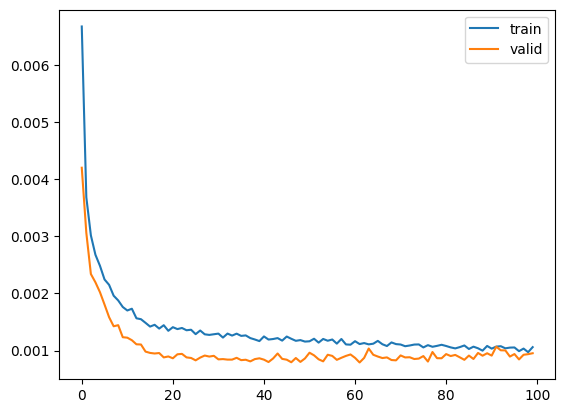

In [56]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show()

In [57]:
model = keras.models.load_model("aq_model5.keras")
calc_mae(model, X_test, y_test)

Mean squared error: 0.00079
Mean absolute error: 0.01493


Adding the additional layer improves the model again, giving us (at least in this run) the best overall model. We'll leave this here, but adding additional layers may be worth testing in this case. As an aside, I ran this over the weekend with 4 years of training data, and a 120 hour (5 day) window, and was able to get the error as low as 0.012 - albeit at a cost of 1 hour of computation time. 

# Exercise

## Appendix

### Beijing pollution dataset: *pollution.csv*

| Column header | Variable |
| --- | --- |
| date | POSIX date (y-m-d h:m:s) |
| pollution | PM2.5 concentration (ppb) |
| dew | Dew point |
| temp | Temperature (C) |
| press | Air pressure (hPa) |
| wnd_dir | Wind direction (categorical) |
| wnd_spd | m s-1 |
| rain | mm |
